### Introduction 
<br/>
Purpose of this notebook

### Import Libraries

In [1]:
import os, sys, time, gc, warnings, re 
import datetime as dt

import itertools as it
import operator as op

import numpy as np
import scipy.stats as stats
import scipy as sp
import pandas as pd

import statsmodels.tsa as smt

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

sys.path.append(os.environ["PY_UTILITIES_LIBRARY"]) # PY_UTILITIES_LIBRARY points to our custom library

%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -iv -d -t -v -w -m

scipy     1.3.0
matplotlib3.0.3
pandas    0.24.2
json      2.0.9
re        2.2.1
seaborn   0.9.0
statsmodels0.9.0
numpy     1.16.4
2019-06-08 16:25:12 

CPython 3.6.8
IPython 7.5.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
watermark 1.8.0


### Configure Notebook

In [3]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('io.hdf.default_format','fixed') # store binary data in HDF5 'table' format or 'fixed' format
sns.set(context='paper', style="darkgrid", rc={'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor':'white'}, 
        font_scale=1.3)
HTML("<style>table {font-size:14px} </style>")

def printmd(string, color=None):
    """colors in hex"""
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [4]:
%reload_ext autoreload
%autoreload 2

rs_seed = np.random.RandomState(seed=43)
warnings.filterwarnings("ignore")

### Define Notebook Parameters

In [7]:
# see papermill package
root_dir = "./av_train"
train_csv = "train.csv"
train_dir = "train_images"
test_dir = "test_images"

In [8]:
# imports
import shutil
from tqdm import tqdm_notebook

from ml_toolbelt.image_processing.image_utils import get_image_paths, get_labels

### Organize images

In [9]:
label_dict = {'Cargo': 1, 
              'Military': 2, 
              'Carrier': 3, 
              'Cruise': 4, 
              'Tankers': 5}

rev_label_dict = {y:x for x,y in label_dict.items()}

# read csv file
train_df = pd.read_csv(root_dir+"/"+train_csv)
train_df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [20]:
test_images = []
train_images = train_df["image"].tolist()
for tst_file in os.listdir(root_dir+"/images"):
    if tst_file not in train_images:
        test_images.append(tst_file)
        
print(len(train_images))
print(len(test_images))

# construct path objects
# class_folder_1 -> images
# class_folder_2 -> images
for row in tqdm_notebook(train_df.itertuples(index=False)):
    dest_path = root_dir+"/"+rev_label_dict[row.category]
    if not os.path.exists(dest_path):
        print("Creating directory:", rev_label_dict[row.category])
        os.mkdir(dest_path)
    shutil.move( root_dir+"/images/"+row.image, dest_path )

6252
2680


Creating directory: Cargo
Creating directory: Military
Creating directory: Carrier
Creating directory: Cruise
Creating directory: Tankers



In [22]:
# clean up
del test_images, train_images, train_df
gc.collect()

87151

### Load images 

In [28]:
all_image_paths = get_image_paths(root_dir+"/"+train_dir)
all_image_labels = get_labels(root_dir+"/"+train_dir, all_image_paths, use_label_encoder=False)

Root Dir: av_train\train_images
Shuffling image paths...
Number of images: 6252
Root Dir: av_train\train_images

Labels:
['Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']

Number of labels: 5
Number of images: 6252


In [30]:
rev_label_dict, label_dict

({1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'},
 {'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5})

In [31]:
# label encode targets
all_image_labels = [label_dict[x] for x in all_image_labels]
all_image_labels[:10]

[4, 5, 2, 1, 2, 2, 3, 1, 4, 1]

### EDA+Train

In [10]:
# imports
from fastai.vision import *

from fastai import metrics as fa_metrics
from fastai.basic_train import *
from fastai.train import *
from fastai.callbacks import *
from fastai.data_block import *

from fastai.utils import mem
from fastai.callbacks.mem import PeakMemMetric

from sklearn.model_selection import train_test_split
from sklearn import metrics

from functools import partial

In [11]:
# identify problematic images that can't be opened with PIL
root_path = Path(root_dir)
for folder in os.listdir(root_path/train_dir):
    verify_images(root_path/train_dir/folder, delete=True, max_workers=1, dest=".")

In [12]:
# reload again
all_image_paths = get_image_paths(root_dir+"/"+train_dir)
all_image_labels = get_labels(root_dir+"/"+train_dir, all_image_paths, use_label_encoder=False)

# label encode targets
all_image_labels = [label_dict[x] for x in all_image_labels]
all_image_labels[:10]

Root Dir: av_train\train_images
Shuffling image paths...
Number of images: 6252
Root Dir: av_train\train_images

Labels:
['Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']

Number of labels: 5
Number of images: 6252


[5, 1, 1, 2, 1, 5, 2, 4, 3, 1]

In [13]:
# create a dataframe of image path and labels
# path | label_integer | class_name
img_df = pd.DataFrame({"img_path": all_image_paths, "target": all_image_labels, "class": [rev_label_dict[x] for x in all_image_labels]})
print(img_df.shape)
img_df.head()

(6252, 3)


,img_path,target,class
0,av_train\train_images\Tankers\2870140.jpg,5,Tankers
1,av_train\train_images\Cargo\2802576.jpg,1,Cargo
2,av_train\train_images\Cargo\2870083.jpg,1,Cargo
3,av_train\train_images\Military\2904775.jpg,2,Military
4,av_train\train_images\Cargo\2788330.jpg,1,Cargo


In [14]:
# validation indices
train_df, valid_df = train_test_split(img_df, test_size=0.2, stratify=img_df["target"], shuffle=True)

train_df["is_valid"] = False
valid_df["is_valid"] = True
img_df = pd.concat([train_df, valid_df], axis=0)

del train_df, valid_df
gc.collect()

print(img_df.shape)
img_df.head()

(6252, 4)


,img_path,target,class,is_valid
2878,av_train\train_images\Cargo\2829324.jpg,1,Cargo,False
5179,av_train\train_images\Cruise\2765808.jpg,4,Cruise,False
4691,av_train\train_images\Military\2862606.jpg,2,Military,False
5843,av_train\train_images\Tankers\2849916.jpg,5,Tankers,False
3878,av_train\train_images\Carrier\2899821.jpg,3,Carrier,False


In [15]:
# image databunch
db = ImageList.from_df(img_df, ".", convert_mode="RGB")
db = db.split_from_df(col="is_valid")  # split_none()
db = db.label_from_df(cols="target"). \
        transform(tfms=get_transforms(), size=224, tfm_y=False). \
        databunch(bs=64, val_bs=None, num_workers=4, device=None)

# scale
db = db.normalize(imagenet_stats)
db

ImageDataBunch;

Train: LabelList (5001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,4,2,5,3
Path: .;

Valid: LabelList (1251 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,2,3,2,5
Path: .;

Test: None

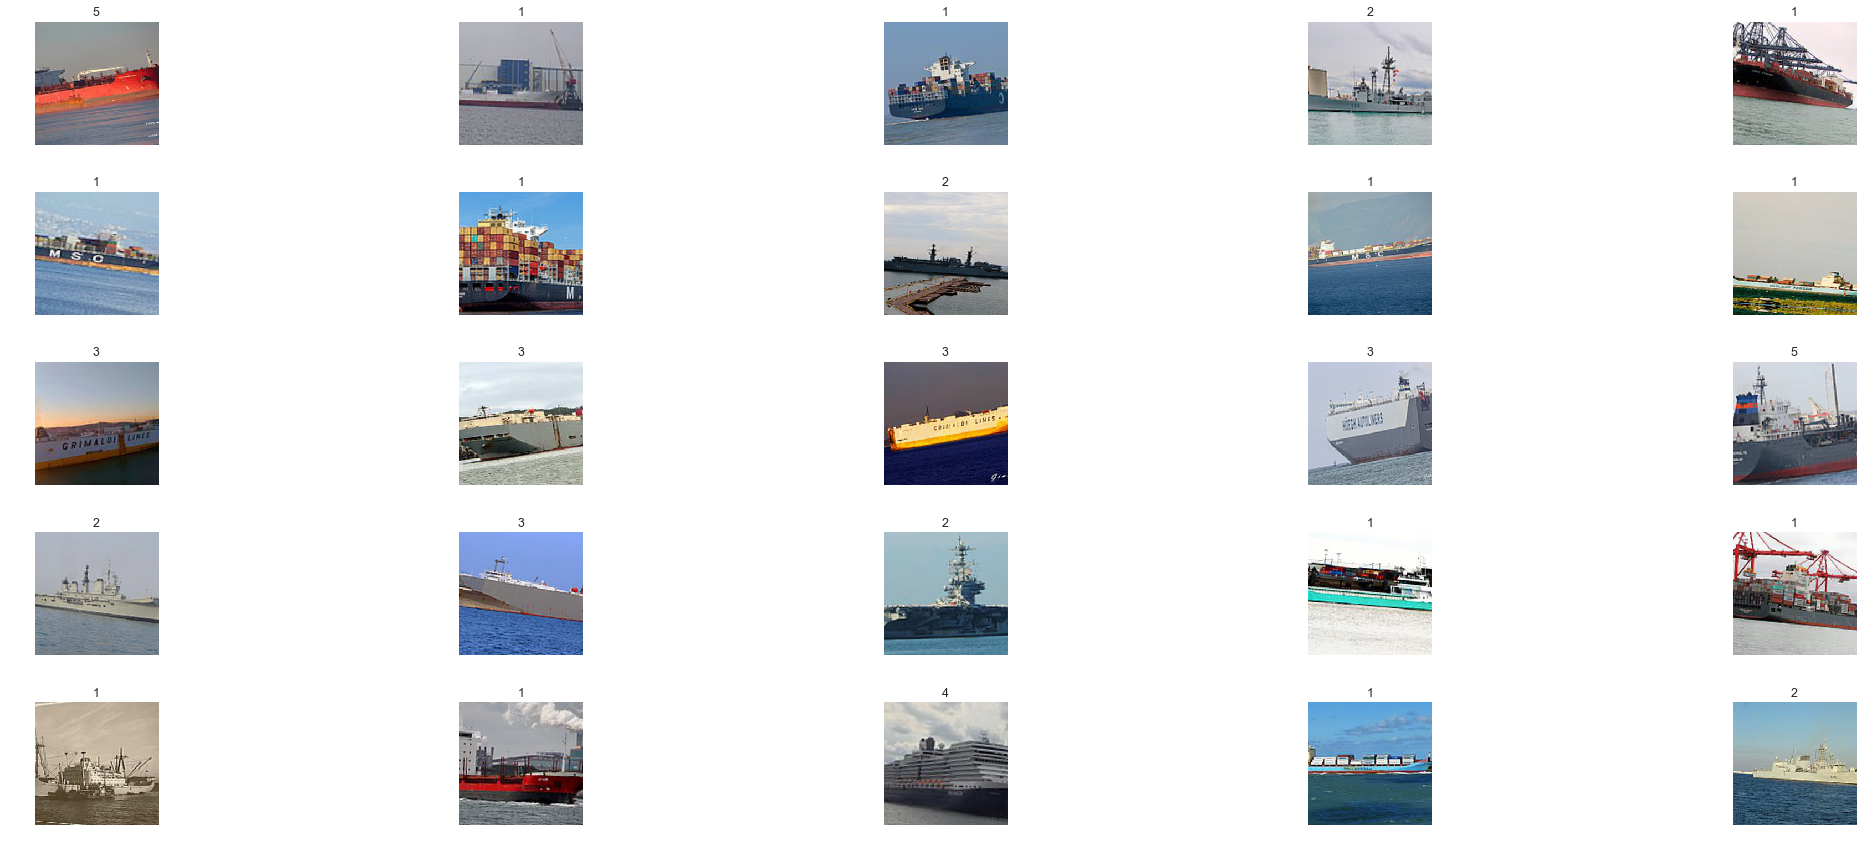

In [44]:
# show batch
db.show_batch(rows = 5, figsize=(32,12))

In [16]:
print(db.classes)
print(db.c)
# per channel pixel means
print( db.batch_stats(ds_type=DatasetType.Train) )

[1, 2, 3, 4, 5]
5
[tensor([0.1257, 0.4845, 0.9229]), tensor([1.0716, 1.0429, 1.0781])]


In [37]:
# convenience functions
def clear_session():
    torch.cuda.empty_cache()
    gc.collect()
    print(mem.gpu_mem_get_all())

### Resnet34

In [18]:
# custom metric
def f1_weighted(preds, actual):
    preds = np.argmax(preds, axis=1)
    #print(preds)
    #print(actual)
    val = metrics.f1_score(actual, preds, average="weighted")
    #print(val)
    return torch.Tensor([val]).cuda()

# train
learner = cnn_learner(db, models.resnet34, metrics=[f1_weighted], model_dir="./models", callback_fns=[PeakMemMetric]) # ps=0, wd=0, PeakMemMetric
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
0.013182567385564075


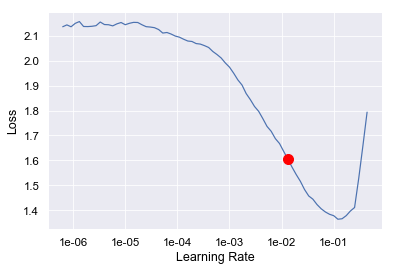

In [19]:
learner.lr_find()
learner.recorder.plot(suggestion=True, return_fig=True)
print(learner.recorder.min_grad_lr)

In [20]:
learner.fit_one_cycle(8, max_lr=1.32e-02)

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.666064,0.459238,0.828258,0,3,98,2520,01:10
1,0.470458,0.492326,0.841463,0,3,0,2274,01:11
2,0.421867,0.472279,0.835407,0,3,0,2274,01:11
3,0.356866,0.338990,0.869595,0,3,0,2274,01:11
4,0.302532,0.324568,0.889822,0,3,0,2274,01:13
5,0.248456,0.288641,0.890864,0,3,0,2274,01:12
6,0.197248,0.210242,0.929354,0,3,0,2274,01:11
7,0.160926,0.205128,0.929741,0,3,0,2274,01:11


In [21]:
# save
learner.save("resnet50_freezed")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
6.309573444801933e-07


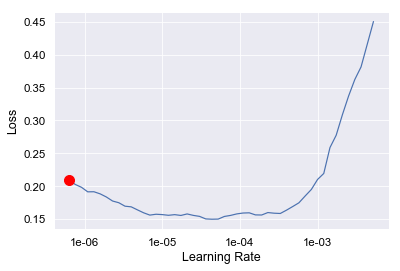

In [22]:
# unfreeze
learner.unfreeze()

learner.lr_find()
learner.recorder.plot(suggestion=True, return_fig=True)
print(learner.recorder.min_grad_lr)

In [24]:
learner.fit_one_cycle(8, max_lr=slice(6.31e-07, 1.32e-02))

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.145482,0.221561,0.918026,0,3,98,1900,01:10
1,0.205326,0.343949,0.890317,0,3,0,1900,01:12
2,0.227517,0.359983,0.894941,0,3,0,1900,01:12
3,0.182631,0.297215,0.913617,0,3,0,1900,01:13
4,0.132140,0.242266,0.925052,0,3,0,1900,01:13
5,0.100504,0.222963,0.927085,0,3,0,1900,01:17
6,0.074507,0.231939,0.926447,0,3,0,1900,01:13
7,0.057810,0.226455,0.932066,0,3,0,1899,01:14


In [25]:
# save
learner.save("resnet50_unfreezed")

### Resnet50

In [39]:
del learner
clear_session()

[GPUMemory(total=8192, free=6599, used=1592)]


In [40]:
# reduce batchsize
db.batch_size = 32

In [47]:
# train
learner = cnn_learner(db, models.resnet50, metrics=[f1_weighted], model_dir="./models", 
                      callback_fns=[PeakMemMetric, 
                                    #partial(EarlyStoppingCallback, monitor="f1_weighted", mode="max", patience=5, min_delta=0.01), # 1% improvement
                                    partial(SaveModelCallback, monitor="f1_weighted", mode="max", every="improvement", name="resnet50_bestmodel")]) # ps=0, wd=0, PeakMemMetric
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
0.007585775750291836


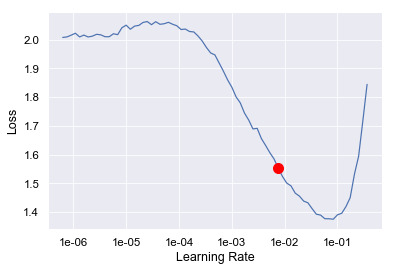

In [44]:
learner.lr_find()
learner.recorder.plot(suggestion=True, return_fig=True)
print(learner.recorder.min_grad_lr)

In [48]:
# a cycle of 20 epochs
learner.fit_one_cycle(20, max_lr=7.59e-03, pct_start=0.3)

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.601177,0.349577,0.875302,0,3,103,2495,01:24
1,0.381813,0.304889,0.884299,0,3,0,2466,01:26
2,0.371468,0.323305,0.883834,0,3,0,2466,01:28
3,0.391915,0.494425,0.823289,0,3,0,2466,01:25
4,0.402615,0.776735,0.734483,0,3,0,2466,01:27
5,0.385199,0.445135,0.849739,0,3,0,2466,01:26
6,0.329636,0.424019,0.855175,0,3,0,2466,01:26
7,0.350256,0.373977,0.863685,0,3,0,2466,01:27
8,0.340969,0.407290,0.860943,0,3,0,2466,01:26
9,0.255538,0.494537,0.847826,0,3,0,2466,01:26


Better model found at epoch 0 with f1_weighted value: 0.8753015398979187.
Better model found at epoch 1 with f1_weighted value: 0.8842993974685669.
Better model found at epoch 10 with f1_weighted value: 0.9096994996070862.
Better model found at epoch 12 with f1_weighted value: 0.9130433201789856.
Better model found at epoch 13 with f1_weighted value: 0.9154592156410217.
Better model found at epoch 14 with f1_weighted value: 0.9255108833312988.
Better model found at epoch 15 with f1_weighted value: 0.928266167640686.
Better model found at epoch 16 with f1_weighted value: 0.9320342540740967.
Better model found at epoch 18 with f1_weighted value: 0.9381946325302124.


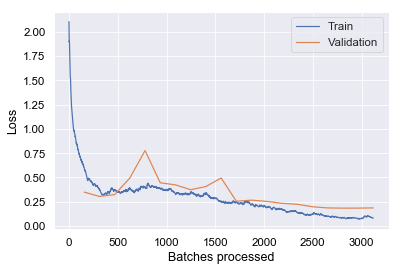

In [49]:
learner.recorder.plot_losses()

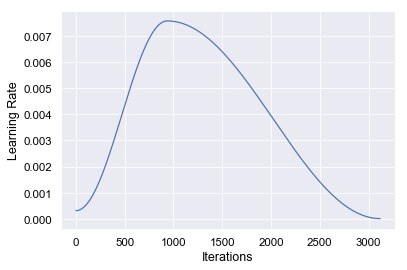

In [50]:
learner.recorder.plot_lr()

In [69]:
def get_total_steps(db, bs=32, total_epochs=20, warm_up_pct=0.3):
    # steps_per_epoch or # of batches / batch updates per epoch
    total_steps = len(db.train_ds) // bs * total_epochs # total batch updates
    print("Steps per epoch: {}".format(len(db.train_ds) // bs))
    print("Total steps: {}".format(total_steps))
    print("Warm up steps: {}".format(int(total_steps * warm_up_pct)))
    
get_total_steps(db)

In [60]:
learner.fit(2, lr=0.0005) # check for few epochs

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.083959,0.196551,0.936639,0,3,24,2485,01:24
1,0.079034,0.208041,0.930706,0,3,0,2485,01:26


Better model found at epoch 0 with f1_weighted value: 0.936638593673706.


### Resnet101

In [61]:
# train
learner101 = cnn_learner(db, models.resnet101, metrics=[f1_weighted], model_dir="./models", 
                          callback_fns=[PeakMemMetric]) 
                                    #partial(EarlyStoppingCallback, monitor="f1_weighted", mode="max", patience=5, min_delta=0.01), # 1% improvement
                                    #partial(SaveModelCallback, monitor="f1_weighted", mode="max", every="improvement", name="resnet50_bestmodel")]) # ps=0, wd=0, PeakMemMetric
learner101.model

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\sneha/.torch\models\resnet101-5d3b4d8f.pth
178728960it [00:07, 22842441.62it/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
0.01096478196143185


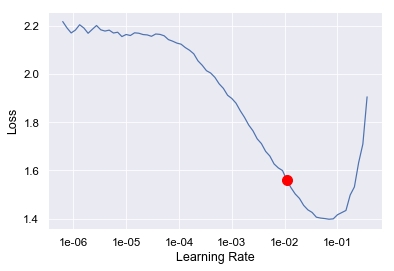

In [62]:
learner101.lr_find()
learner101.recorder.plot(suggestion=True, return_fig=True)
print(learner101.recorder.min_grad_lr)

In [66]:
print(len(learner101.layer_groups))
#learner101.summary()

3


In [75]:
# a cycle of 8 epochs
learner101.fit_one_cycle(8, max_lr=1.10e-02, pct_start=0.05)

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.451895,0.556967,0.827269,0,3,24,3817,01:54
1,0.368139,0.554899,0.829276,0,3,0,3818,01:56
2,0.303947,0.424622,0.862899,0,3,0,3818,01:57
3,0.263427,0.295144,0.892404,0,3,0,3817,01:57
4,0.220663,0.254144,0.907982,0,3,0,3818,01:57
5,0.177191,0.187895,0.928577,0,3,0,3817,01:57
6,0.149489,0.188152,0.930517,0,3,0,3818,01:58
7,0.121423,0.190899,0.933710,0,3,0,3818,01:57


In [76]:
learner101.save("resnet101_model")

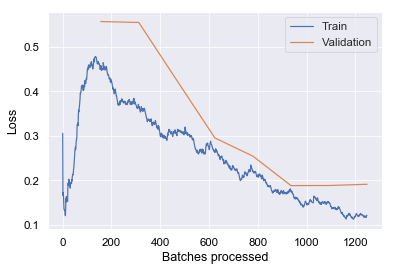

In [77]:
learner101.recorder.plot_losses()

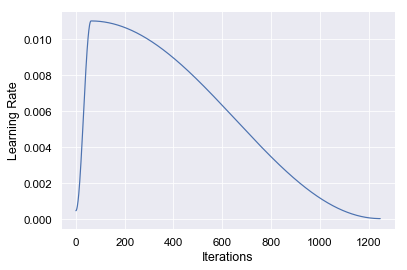

In [78]:
learner101.recorder.plot_lr()

In [81]:
learner101.fit_one_cycle(8, max_lr=1e-3, pct_start=0.05)

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.112468,0.191109,0.937591,2,5,78,3806,01:55
1,0.114878,0.197045,0.930365,0,3,0,3768,01:58
2,0.104110,0.188480,0.938897,0,3,0,3768,01:58
3,0.098047,0.190003,0.937887,0,3,0,3769,01:59
4,0.091877,0.182865,0.943794,0,3,0,3769,01:59
5,0.089918,0.196495,0.939646,0,3,0,3768,01:59
6,0.087811,0.197224,0.938578,0,3,0,3769,01:59
7,0.087797,0.190795,0.940340,0,3,0,3769,01:59


In [93]:
learner101.save("resnet101_model")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
7.585775750291837e-07


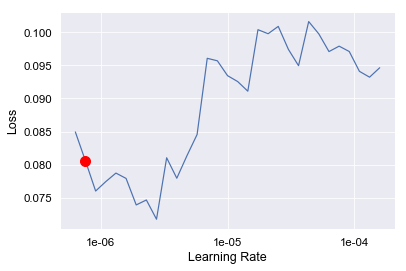

In [83]:
# unfreeze and train
learner101.unfreeze()

learner101.lr_find()
learner101.recorder.plot(suggestion=True, return_fig=True)
print(learner101.recorder.min_grad_lr)

In [92]:
learner101.fit_one_cycle(10, max_lr=slice(7.59e-07), pct_start=0.1)

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.078239,0.184020,0.940556,0,3,352,3311,02:23
1,0.084516,0.195296,0.937969,0,3,0,3580,02:24
2,0.080947,0.184286,0.941134,0,3,0,3581,02:25
3,0.080202,0.196768,0.937742,0,3,0,3581,02:29
4,0.086576,0.190167,0.939479,0,3,0,3581,02:28
5,0.083208,0.188361,0.946807,0,3,0,3580,02:29
6,0.073730,0.183312,0.942801,0,3,0,3581,02:28
7,0.095271,0.186480,0.944449,0,3,0,3581,02:29
8,0.090346,0.187083,0.943636,0,3,0,3581,02:29
9,0.089051,0.191139,0.940224,0,3,0,3581,02:29


In [98]:
# explain
intrp = ClassificationInterpretation.from_learner(learner101, ds_type=DatasetType.Train)

In [99]:
intrp.most_confused(min_val=3)
# cargo and tankers are difficult to separate
# tankers are subtypes of cargo ships, so difficult to find discriminating features

[(1, 5, 32), (5, 1, 31), (1, 4, 3), (4, 2, 3), (5, 2, 3)]

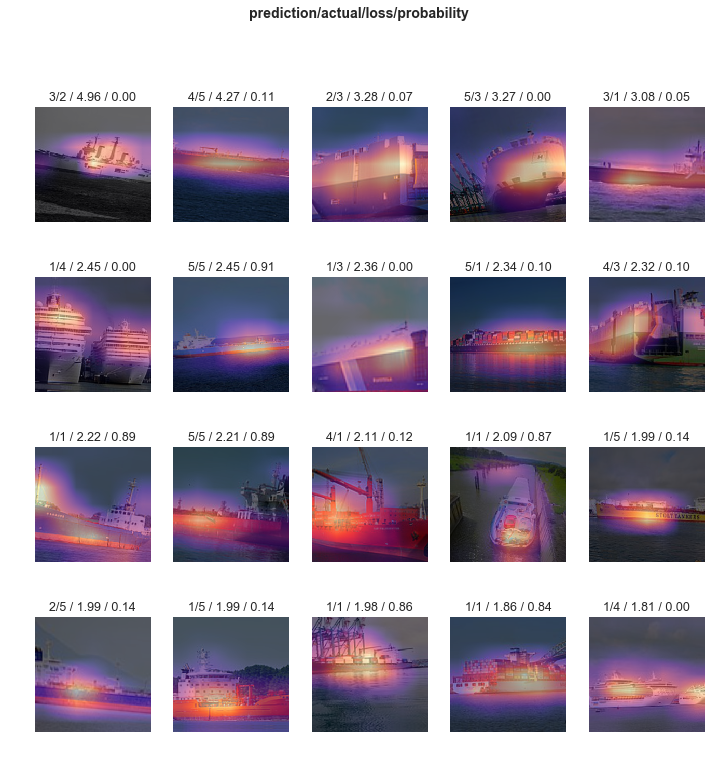

In [100]:
intrp.plot_top_losses(20)

In [101]:
# TTA ; Oversampling
preds = learner101.TTA(ds_type=DatasetType.Valid) # retuns tuple of torch ndarray of n x classes, actual labels

In [104]:
y_pred = np.argmax(preds[0].numpy(), axis=1)
metrics.f1_score(preds[1].numpy(), y_pred, average="weighted")

0.9405379307045494

In [110]:
# prepare test set
root_path = Path(root_dir)
test_files = [root_path/test_dir/x for x in os.listdir(root_path/test_dir)]
print(test_files[:5])

db.add_test(test_files, label=None)
db

[WindowsPath('av_train/test_images/1007700.jpg'), WindowsPath('av_train/test_images/1011369.jpg'), WindowsPath('av_train/test_images/1051155.jpg'), WindowsPath('av_train/test_images/1062001.jpg'), WindowsPath('av_train/test_images/1069397.jpg')]


ImageDataBunch;

Train: LabelList (5001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,4,2,5,3
Path: .;

Valid: LabelList (1251 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,2,3,2,5
Path: .;

Test: LabelList (2680 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: .

In [112]:
# predictions with oversampling
test_preds = learner101.TTA(ds_type=DatasetType.Test) # retuns tuple of torch ndarray of n x classes, actual labels

In [127]:
y_test = np.argmax(test_preds[0], axis=1) + 1
test_df = pd.DataFrame({'image': [x.name for x in db.test_ds.x.items], "category": y_test})
print(test_df.shape)

test_df.to_csv("./submission.csv", index=False)
test_df.head()

# LEADERBOARD SCORE: 0.9543

(2680, 2)


,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [138]:
# predictions without oversampling
try_preds, _ = learner101.get_preds(ds_type=DatasetType.Test)

In [149]:
test_df["category_prob"] = np.max(test_preds[0].numpy(), axis=1)
test_df["pred_wo_sampling"] = (np.argmax(try_preds, axis=1) + 1).numpy()
test_df["pred_wo_sampling_prob"] = np.max(try_preds.numpy(), axis=1)

test_df.head()

,image,category,category_prob,pred_wo_sampling,pred_wo_sampling_prob
0,1007700.jpg,4,0.999,4,0.999
1,1011369.jpg,4,1.000,4,1.000
2,1051155.jpg,4,0.999,4,1.000
3,1062001.jpg,2,0.978,2,1.000
4,1069397.jpg,4,0.794,4,1.000


In [150]:
# differences in confidence in predictions between no sampling vs. oversampling
test_df[test_df["category"] != test_df["pred_wo_sampling"]]

# difficult images: 
#  2408178.jpg

,image,category,category_prob,pred_wo_sampling,pred_wo_sampling_prob
20,1131990.jpg,2,0.739,1,0.526
197,1942198.jpg,2,0.546,4,0.663
219,2038316.jpg,2,0.434,5,0.725
221,2042418.jpg,1,0.553,4,0.769
260,2159094.jpg,2,0.691,1,0.723
347,2408178.jpg,2,0.422,5,0.505
363,2492390.jpg,2,0.555,5,0.446
618,2786121.jpg,5,0.478,1,0.717
824,2802505.jpg,1,0.500,5,0.641
867,2804762.jpg,5,0.446,1,0.685


In [154]:
def choose_largest(x):
    if x["category_prob"] > x["pred_wo_sampling_prob"]:
        return x["category"]
    return x["pred_wo_sampling"]

test_df["new_category"] = test_df.apply(lambda x: x["category"] if x["category"] == x["pred_wo_sampling"] else choose_largest(x), axis=1)
test_df.head()

,image,category,category_prob,pred_wo_sampling,pred_wo_sampling_prob,new_category
0,1007700.jpg,4,0.999,4,0.999,4
1,1011369.jpg,4,1.000,4,1.000,4
2,1051155.jpg,4,0.999,4,1.000,4
3,1062001.jpg,2,0.978,2,1.000,2
4,1069397.jpg,4,0.794,4,1.000,4


In [157]:
test_new_df = test_df[["image", "new_category"]].rename(columns = {"new_category": "category"})
test_new_df.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [158]:
test_new_df.to_csv("./submission_mixed.csv", index=False)
# LEADERBOARD SCORE: 0.9487